In [1]:
from icecream import ic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from miscellaneous.loader import load_image
from miscellaneous.propagator import angular_spectrum_band_limited
from miscellaneous.tie import FFTSolver2D

In [2]:
file = '../../generation/image/BMSTU 1024x1024.png'
phase = load_image(file) + 0.2

In [3]:
i_amplitude = 0.5
intensity = i_amplitude * np.ones(phase.shape)

mean = 0.0
standard_deviation = 0.001
noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_back_propagation = np.sqrt(intensity) * np.exp(1j * phase)

noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_forward_propagation = np.sqrt(intensity) * np.exp(1j * phase)

In [4]:
start=0.000010  # 10 mkm
stop=0.002500  # 2500 mkm
step=0.000010  # 10 mkm

px_size = 0.000005  # 5 mkm
wavelength = 0.000000555  # 555 nm

distances = np.arange(start, stop + step, step)
forward_propagated_fields = []
for distance in distances:
    ic(distance)
    complex_field = np.copy(complex_field_forward_propagation)
    forward_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

ic| distance: 1e-05
ic| distance: 2e-05
ic| distance: 3.0000000000000004e-05
ic| distance: 4e-05
ic| distance: 5e-05
ic| distance: 6e-05
ic| distance: 7.000000000000001e-05
ic| distance: 8e-05
ic| distance: 9e-05
ic| distance: 0.0001
ic| distance: 0.00011
ic| distance: 0.00012
ic| distance: 0.00013000000000000002
ic| distance: 0.00014000000000000001
ic| distance: 0.00015000000000000001
ic| distance: 0.00016
ic| distance: 0.00017
ic| distance: 0.00018
ic| distance: 0.00019
ic| distance: 0.0002
ic| distance: 0.00021
ic| distance: 0.00022
ic| distance: 0.00023
ic| distance: 0.00024
ic| distance: 0.00025000000000000006
ic| distance: 0.00026000000000000003
ic| distance: 0.00027000000000000006
ic| distance: 0.00028000000000000003
ic| distance: 0.00029000000000000006
ic| distance: 0.00030000000000000003
ic| distance: 0.00031000000000000005
ic| distance: 0.00032
ic| distance: 0.00033000000000000005
ic| distance: 0.0003400000000000001
ic| distance: 0.00035000000000000005
ic| distance: 0.0003600

In [5]:
start=-0.000010  # -10 mkm
stop=-0.002500  # -2500 mkm
step=-0.000010  # -10 mkm

distances = np.arange(start, stop + step, step)
back_propagated_fields = []
for distance in distances:
    ic(distance)
    complex_field = np.copy(complex_field_back_propagation)
    back_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

ic| distance: -1e-05
ic| distance: -2e-05
ic| distance: -3.0000000000000004e-05
ic| distance: -4e-05
ic| distance: -5e-05
ic| distance: -6e-05
ic| distance: -7.000000000000001e-05
ic| distance: -8e-05
ic| distance: -9e-05
ic| distance: -0.0001
ic| distance: -0.00011
ic| distance: -0.00012
ic| distance: -0.00013000000000000002
ic| distance: -0.00014000000000000001
ic| distance: -0.00015000000000000001
ic| distance: -0.00016
ic| distance: -0.00017
ic| distance: -0.00018
ic| distance: -0.00019
ic| distance: -0.0002
ic| distance: -0.00021
ic| distance: -0.00022
ic| distance: -0.00023
ic| distance: -0.00024
ic| distance: -0.00025000000000000006
ic| distance: -0.00026000000000000003
ic| distance: -0.00027000000000000006
ic| distance: -0.00028000000000000003
ic| distance: -0.00029000000000000006
ic| distance: -0.00030000000000000003
ic| distance: -0.00031000000000000005
ic| distance: -0.00032
ic| distance: -0.00033000000000000005
ic| distance: -0.0003400000000000001
ic| distance: -0.000350000

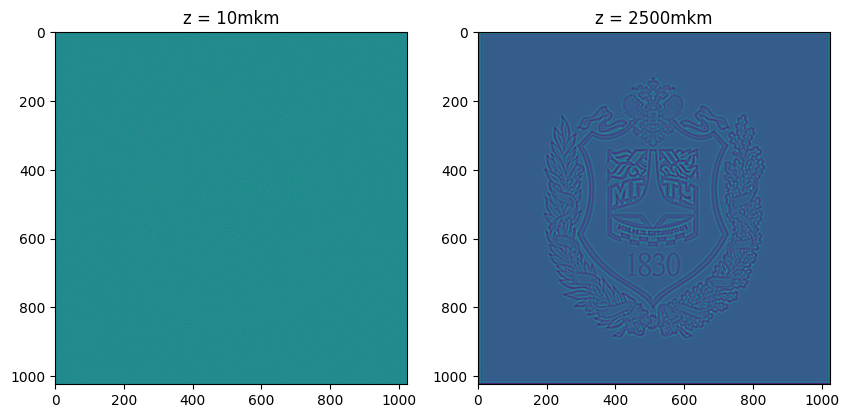

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(np.abs(forward_propagated_fields[0])**2)
ax1.set_title('z = 10mkm')
ax2.imshow(np.abs(forward_propagated_fields[-1])**2)
ax2.set_title('z = 2500mkm')

plt.show()

In [7]:
start=0.000010  # 10 mkm
stop=0.002500  # 1000 mkm
step=0.000010  # 10 mkm

distances = np.arange(start, stop + step, step)
retrieved_phases = {}
for dz, i in zip(distances, range(len(distances))):
    ic(dz)
    intensities = [np.abs(field) ** 2 for field in [forward_propagated_fields[i], back_propagated_fields[i]]]

    dz = 2 * dz
    dz = - dz
    threshold = 0.1

    solver = FFTSolver2D(intensities, dz, wavelength, px_size)
    retrieved_phases[-dz] = solver.solve(threshold)

ic| dz: 1e-05
ic| dz: 2e-05
ic| dz: 3.0000000000000004e-05
ic| dz: 4e-05
ic| dz: 5e-05
ic| dz: 6e-05
ic| dz: 7.000000000000001e-05
ic| dz: 8e-05
ic| dz: 9e-05
ic| dz: 0.0001
ic| dz: 0.00011
ic| dz: 0.00012
ic| dz: 0.00013000000000000002
ic| dz: 0.00014000000000000001
ic| dz: 0.00015000000000000001
ic| dz: 0.00016
ic| dz: 0.00017
ic| dz: 0.00018
ic| dz: 0.00019
ic| dz: 0.0002
ic| dz: 0.00021
ic| dz: 0.00022
ic| dz: 0.00023
ic| dz: 0.00024
ic| dz: 0.00025000000000000006
ic| dz: 0.00026000000000000003
ic| dz: 0.00027000000000000006
ic| dz: 0.00028000000000000003
ic| dz: 0.00029000000000000006
ic| dz: 0.00030000000000000003
ic| dz: 0.00031000000000000005
ic| dz: 0.00032
ic| dz: 0.00033000000000000005
ic| dz: 0.0003400000000000001
ic| dz: 0.00035000000000000005
ic| dz: 0.0003600000000000001
ic| dz: 0.00037000000000000005
ic| dz: 0.0003800000000000001
ic| dz: 0.00039000000000000005
ic| dz: 0.0004000000000000001
ic| dz: 0.00041000000000000005
ic| dz: 0.00042000000000000007
ic| dz: 0.000430000

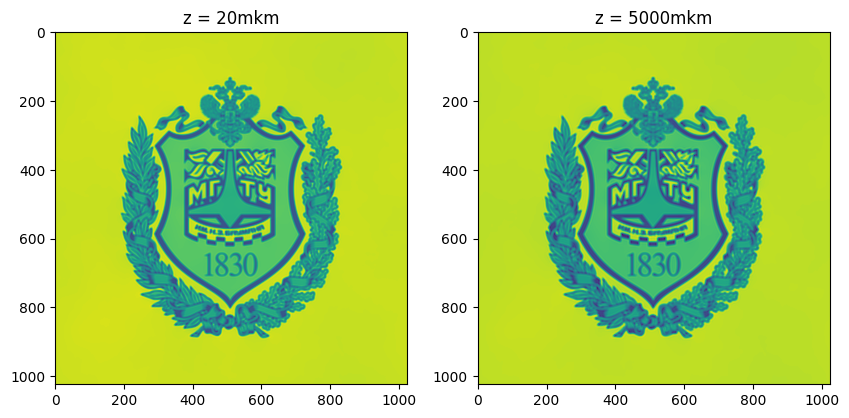

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(retrieved_phases[0.004])
ax1.set_title('z = 20mkm')
ax2.imshow(retrieved_phases[0.005])
ax2.set_title('z = 5000mkm')

plt.show()

In [78]:
def find_power(data: np.ndarray, threshold:int=0.01) -> int:
    threshold /= 1000
    power = 0
    counter = 0
    for i in data:
        for j in i:
            if (j - counter) ** 2 > threshold: power += j ** 2
            counter = j
        counter = 0

    return power

powers = {}

for dz, phase in retrieved_phases.items():
    ic(dz)
    powers[dz] = find_power(phase)

ic| dz: 2e-05
ic| dz: 4e-05
ic| dz: 6.000000000000001e-05
ic| dz: 8e-05
ic| dz: 0.0001
ic| dz: 0.00012
ic| dz: 0.00014000000000000001
ic| dz: 0.00016
ic| dz: 0.00018
ic| dz: 0.0002
ic| dz: 0.00022
ic| dz: 0.00024
ic| dz: 0.00026000000000000003
ic| dz: 0.00028000000000000003
ic| dz: 0.00030000000000000003
ic| dz: 0.00032
ic| dz: 0.00034
ic| dz: 0.00036
ic| dz: 0.00038
ic| dz: 0.0004
ic| dz: 0.00042
ic| dz: 0.00044
ic| dz: 0.00046
ic| dz: 0.00048
ic| dz: 0.0005000000000000001
ic| dz: 0.0005200000000000001
ic| dz: 0.0005400000000000001
ic| dz: 0.0005600000000000001
ic| dz: 0.0005800000000000001
ic| dz: 0.0006000000000000001
ic| dz: 0.0006200000000000001
ic| dz: 0.00064
ic| dz: 0.0006600000000000001
ic| dz: 0.0006800000000000002
ic| dz: 0.0007000000000000001
ic| dz: 0.0007200000000000002
ic| dz: 0.0007400000000000001
ic| dz: 0.0007600000000000002
ic| dz: 0.0007800000000000001
ic| dz: 0.0008000000000000001
ic| dz: 0.0008200000000000001
ic| dz: 0.0008400000000000001
ic| dz: 0.000860000000000

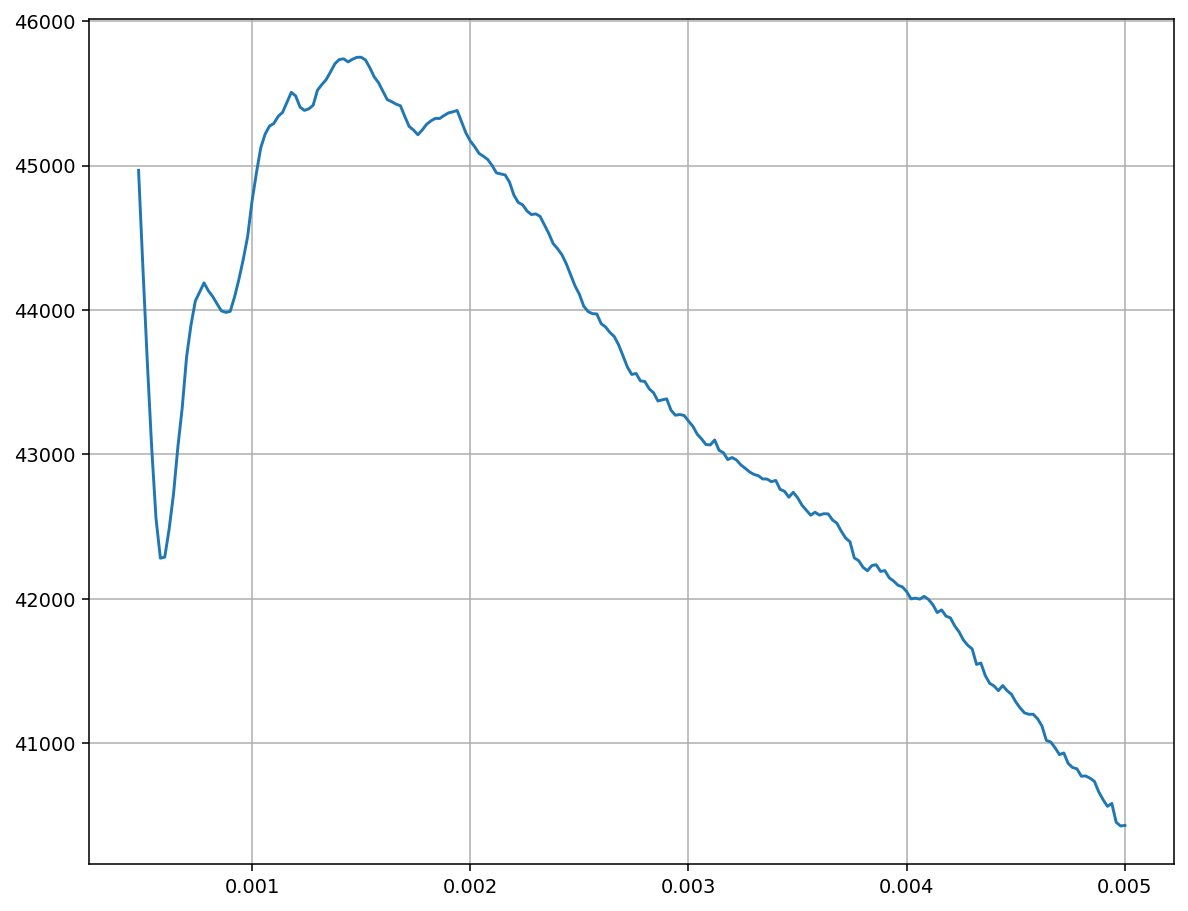

In [102]:
normal_powers = {k: v for k, v in powers.items() if k > 0.00046}

figure(figsize=(10, 8), dpi=140)
plt.plot(normal_powers.keys(), normal_powers.values())
plt.grid()
plt.show()

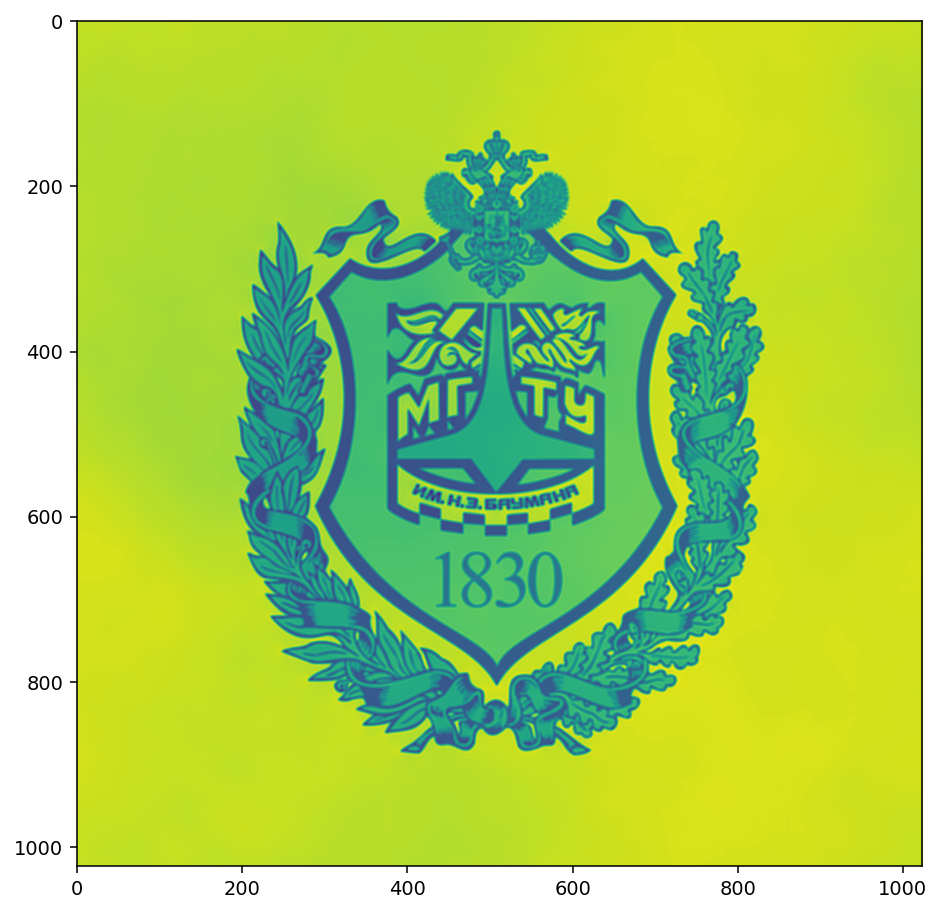

In [106]:
figure(figsize=(10, 8), dpi=140)
plt.imshow(retrieved_phases[max(normal_powers, key=normal_powers.get)])
plt.show()

In [9]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.0001
        row_power = 0
        for i in range(a.size - 1):
            if a[i+1] - a[i] >= th: row_power += (a[i+1] - a[i])**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

powers = {}

for dz, phase in retrieved_phases.items():
    powers[dz] = find_power(phase)
    ic(dz, powers[dz])

ic| dz: 2e-05, powers[dz]: 5745.9930562680665
ic| dz: 4e-05, powers[dz]: 5460.739146129446
ic| dz: 6.000000000000001e-05, powers[dz]: 5408.027795669145
ic| dz: 8e-05, powers[dz]: 5383.024016120531
ic| dz: 0.0001, powers[dz]: 5360.677882473064
ic| dz: 0.00012, powers[dz]: 5333.480088696093
ic| dz: 0.00014000000000000001, powers[dz]: 5297.6809873550155
ic| dz: 0.00016, powers[dz]: 5251.182955150838
ic| dz: 0.00018, powers[dz]: 5193.2018191776715
ic| dz: 0.0002, powers[dz]: 5124.126256877085
ic| dz: 0.00022, powers[dz]: 5045.262785367127
ic| dz: 0.00024, powers[dz]: 4958.460591231893
ic| dz: 0.00026000000000000003, powers[dz]: 4865.765288026332
ic| dz: 0.00028000000000000003, powers[dz]: 4769.146791198908
ic| dz: 0.00030000000000000003, powers[dz]: 4670.358918901171
ic| dz: 0.00032, powers[dz]: 4570.91677337436
ic| dz: 0.00034, powers[dz]: 4472.1087139332385
ic| dz: 0.00036, powers[dz]: 4375.016599352528
ic| dz: 0.00038, powers[dz]: 4280.52284317311
ic| dz: 0.0004, powers[dz]: 4189.296623

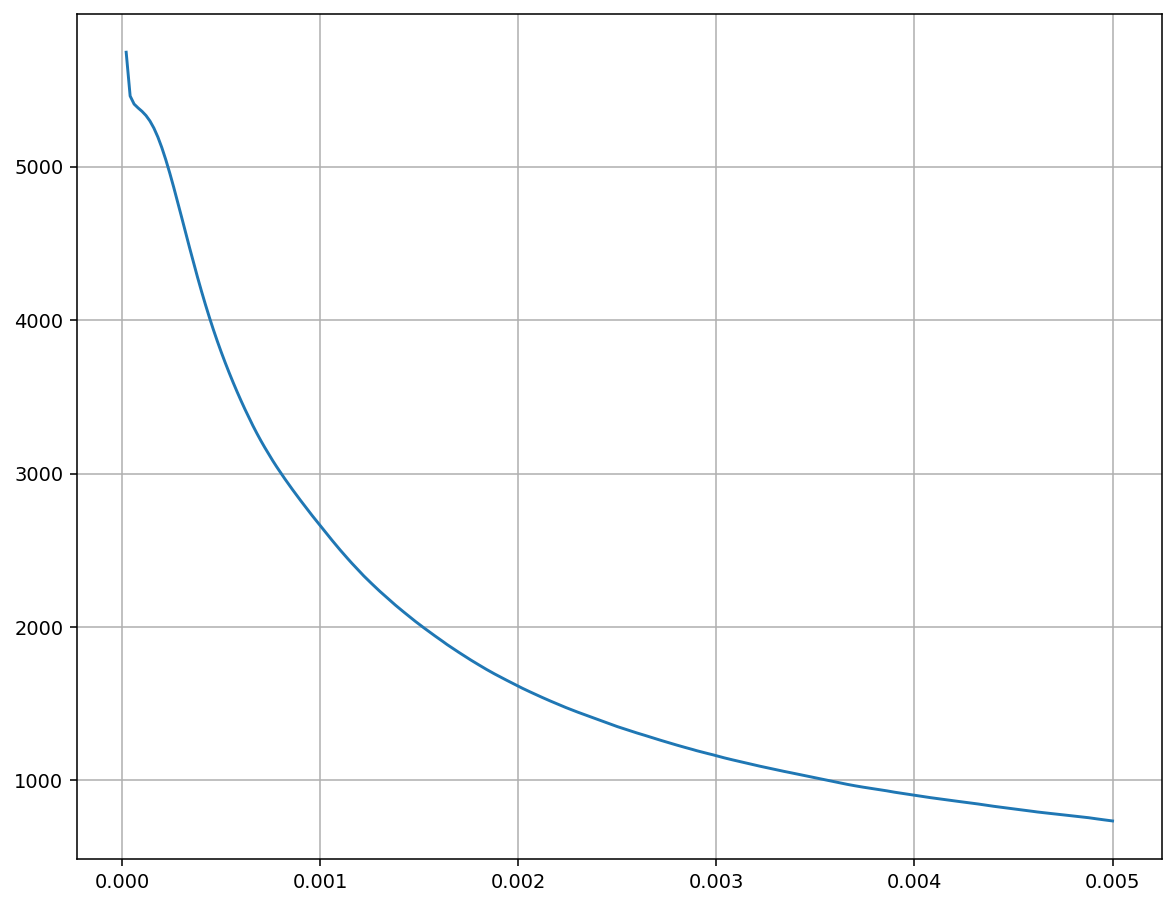

In [10]:
figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()

ic| dz: 2e-05, powers[dz]: 9912017.889206108
ic| dz: 4e-05, powers[dz]: 2291980.0887480704
ic| dz: 6.000000000000001e-05, powers[dz]: 964243.1582964486
ic| dz: 8e-05, powers[dz]: 530882.4077006971
ic| dz: 0.0001, powers[dz]: 344948.63243307377
ic| dz: 0.00012, powers[dz]: 251707.77562888025
ic| dz: 0.00014000000000000001, powers[dz]: 199880.6793014009
ic| dz: 0.00016, powers[dz]: 168692.44788295697
ic| dz: 0.00018, powers[dz]: 148874.45235242293
ic| dz: 0.0002, powers[dz]: 135438.53215701148
ic| dz: 0.00022, powers[dz]: 125902.33621387286
ic| dz: 0.00024, powers[dz]: 118953.86957838117
ic| dz: 0.00026000000000000003, powers[dz]: 113608.17019132627
ic| dz: 0.00028000000000000003, powers[dz]: 109279.25106788252
ic| dz: 0.00030000000000000003, powers[dz]: 105713.98115553503
ic| dz: 0.00032, powers[dz]: 102753.9310754861
ic| dz: 0.00034, powers[dz]: 100314.22866821381
ic| dz: 0.00036, powers[dz]: 98017.54699122788
ic| dz: 0.00038, powers[dz]: 96049.14605802385
ic| dz: 0.0004, powers[dz]: 9

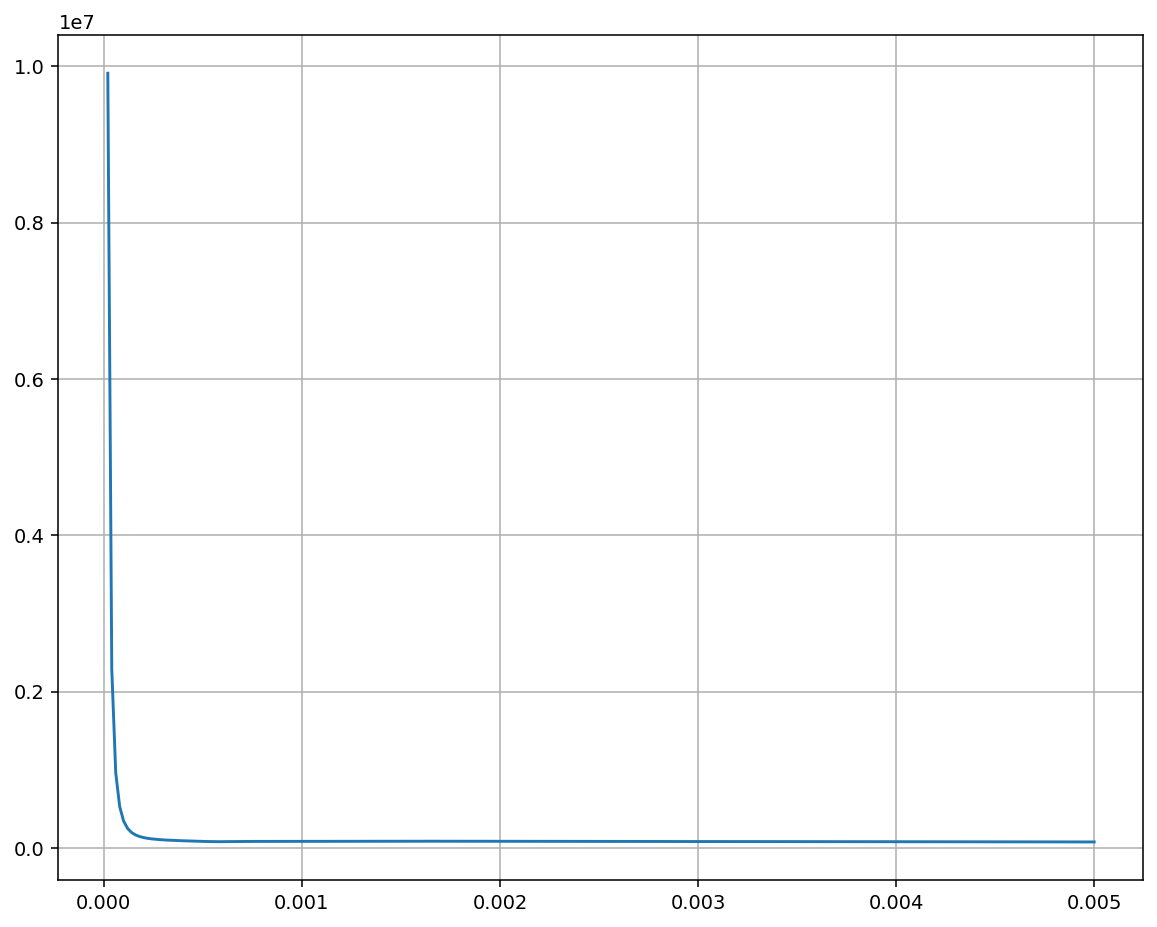

In [150]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.00001
        row_power = 0
        for i in range(a.size - 1):
            if (a[i+1] - a[i])**2 >= th: row_power += a[i+1]**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

powers = {}

for dz, phase in retrieved_phases.items():
    powers[dz] = find_power(phase)
    ic(dz, powers[dz])

figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()

ic| dz: 2e-05, powers[dz]: 5734.379140704628
ic| dz: 4e-05, powers[dz]: 5442.125890480157
ic| dz: 6.000000000000001e-05, powers[dz]: 5387.616814370017
ic| dz: 8e-05, powers[dz]: 5364.161049548604
ic| dz: 0.0001, powers[dz]: 5004.950636753075
ic| dz: 0.00012, powers[dz]: 4989.478601486902
ic| dz: 0.00014000000000000001, powers[dz]: 4599
ic| dz: 0.00016, powers[dz]: 4562
ic| dz: 0.00018, powers[dz]: 4492
ic| dz: 0.0002, powers[dz]: 4440
ic| dz: 0.00022, powers[dz]: 4359
ic| dz: 0.00024, powers[dz]: 4287
ic| dz: 0.00026000000000000003, powers[dz]: 4189
ic| dz: 0.00028000000000000003, powers[dz]: 4092
ic| dz: 0.00030000000000000003, powers[dz]: 3971
ic| dz: 0.00032, powers[dz]: 3860
ic| dz: 0.00034, powers[dz]: 3754
ic| dz: 0.00036, powers[dz]: 3654
ic| dz: 0.00038, powers[dz]: 3556
ic| dz: 0.0004, powers[dz]: 3468
ic| dz: 0.00042, powers[dz]: 3398
ic| dz: 0.00044, powers[dz]: 3308
ic| dz: 0.00046, powers[dz]: 3232
ic| dz: 0.00048, powers[dz]: 3159
ic| dz: 0.0005000000000000001, powers[dz]

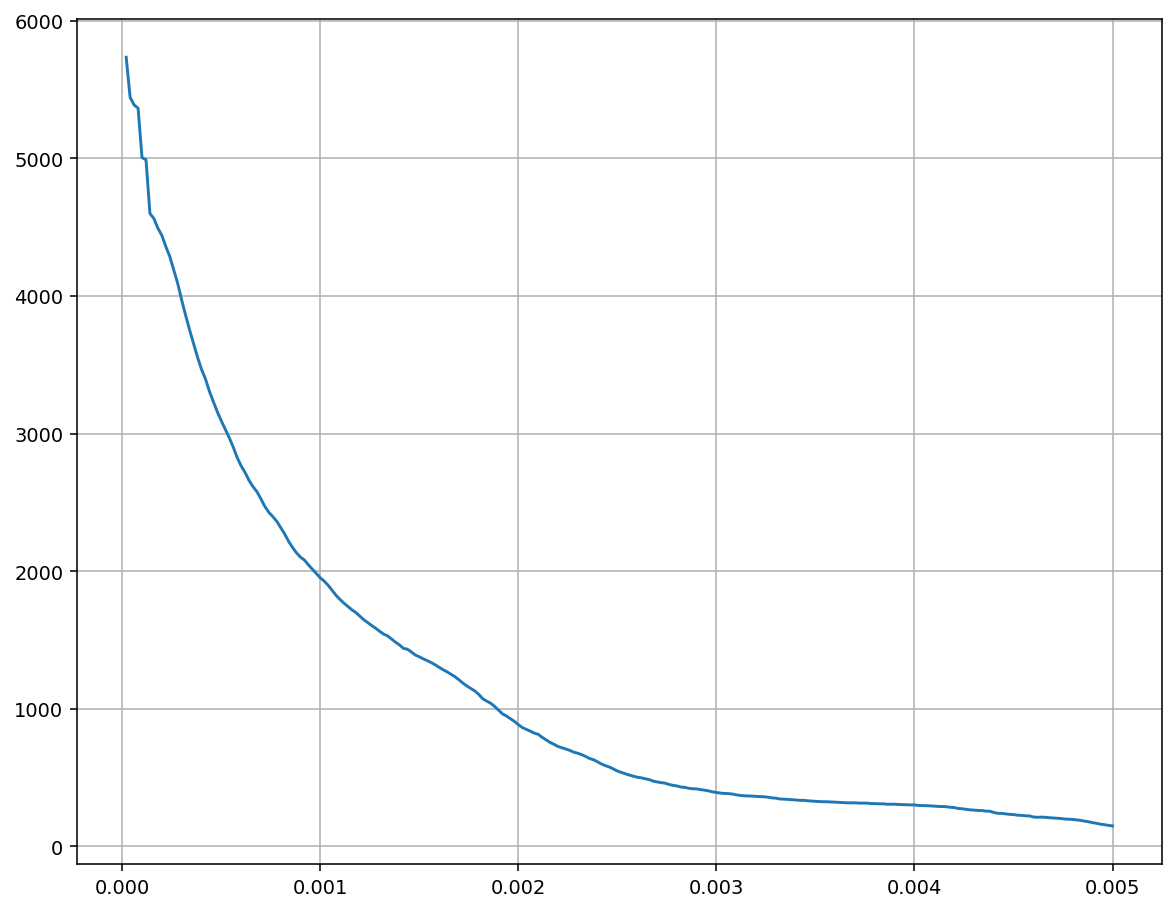

In [11]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.01
        row_power = 0
        for i in range(a.size - 1):
            if a[i+1] - a[i] >= th: row_power += (a[i+1] - a[i])**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

powers = {}

for dz, phase in retrieved_phases.items():
    powers[dz] = find_power(phase)
    ic(dz, powers[dz])

figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()

ic| dz: 2e-05, powers[dz]: 5745.980590500623
ic| dz: 4e-05, powers[dz]: 5460.714566477938
ic| dz: 6.000000000000001e-05, powers[dz]: 5407.992507261653
ic| dz: 8e-05, powers[dz]: 5382.978798675437
ic| dz: 0.0001, powers[dz]: 5360.623561463317
ic| dz: 0.00012, powers[dz]: 5333.417298816867
ic| dz: 0.00014000000000000001, powers[dz]: 5297.610189709422
ic| dz: 0.00016, powers[dz]: 5251.10434237604
ic| dz: 0.00018, powers[dz]: 5193.1160359866335
ic| dz: 0.0002, powers[dz]: 5124.033292692608
ic| dz: 0.00022, powers[dz]: 5045.162814752537
ic| dz: 0.00024, powers[dz]: 4958.354146946078
ic| dz: 0.00026000000000000003, powers[dz]: 4865.652343888971
ic| dz: 0.00028000000000000003, powers[dz]: 4769.027589570526
ic| dz: 0.00030000000000000003, powers[dz]: 4670.2338560283515
ic| dz: 0.00032, powers[dz]: 4570.786469501978
ic| dz: 0.00034, powers[dz]: 4471.973502298861
ic| dz: 0.00036, powers[dz]: 4374.87671305858
ic| dz: 0.00038, powers[dz]: 4280.378767220967
ic| dz: 0.0004, powers[dz]: 4189.14856479

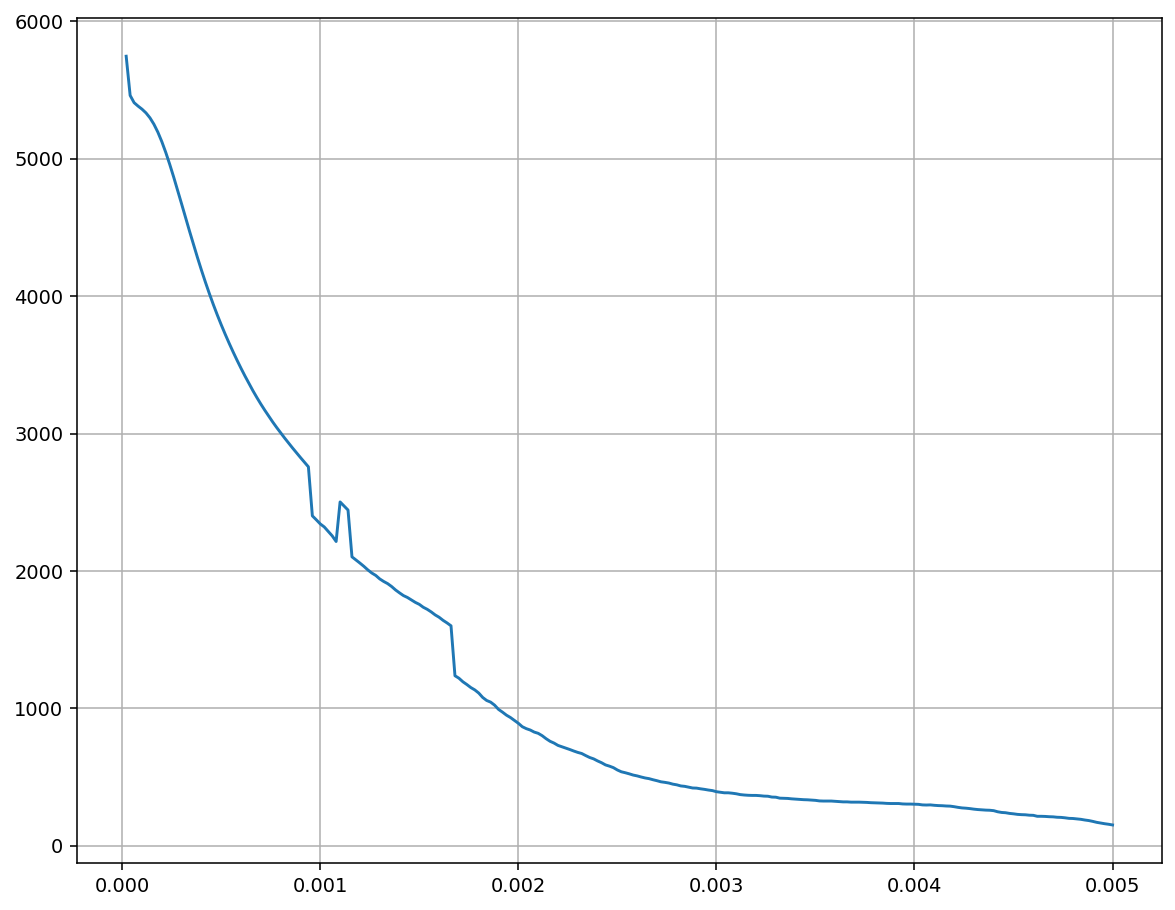

In [12]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.001
        row_power = 0
        for i in range(a.size - 1):
            if a[i+1] - a[i] >= th: row_power += (a[i+1] - a[i])**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

powers = {}

for dz, phase in retrieved_phases.items():
    powers[dz] = find_power(phase)
    ic(dz, powers[dz])

figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()

In [31]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.00001
        row_power = 0
        for i in range(a.size - 1):
            if a[i+1] - a[i] >= th: row_power += a[i+1]**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

powers = {}

for dz, phase in retrieved_phases.items():
    powers[dz] = find_power(phase)
    ic(dz, powers[dz])

ic| dz: 2e-05, powers[dz]: 2888576.5370681845
ic| dz: 4e-05, powers[dz]: 732855.3273573293
ic| dz: 6.000000000000001e-05, powers[dz]: 340635.08637839067
ic| dz: 8e-05, powers[dz]: 206133.4566457186
ic| dz: 0.0001, powers[dz]: 145422.35202363358
ic| dz: 0.00012, powers[dz]: 113597.64188804998
ic| dz: 0.00014000000000000001, powers[dz]: 95235.58417787621
ic| dz: 0.00016, powers[dz]: 83877.57034102091
ic| dz: 0.00018, powers[dz]: 76489.73857462045
ic| dz: 0.0002, powers[dz]: 71429.45981621204
ic| dz: 0.00022, powers[dz]: 67895.85646533302
ic| dz: 0.00024, powers[dz]: 65298.234650184204
ic| dz: 0.00026000000000000003, powers[dz]: 63321.13700381888
ic| dz: 0.00028000000000000003, powers[dz]: 61855.82393234037
ic| dz: 0.00030000000000000003, powers[dz]: 60677.25833011191
ic| dz: 0.00032, powers[dz]: 59806.78821708577
ic| dz: 0.00034, powers[dz]: 59087.020825478525
ic| dz: 0.00036, powers[dz]: 58483.682090355345
ic| dz: 0.00038, powers[dz]: 57971.15141381864
ic| dz: 0.0004, powers[dz]: 57533.

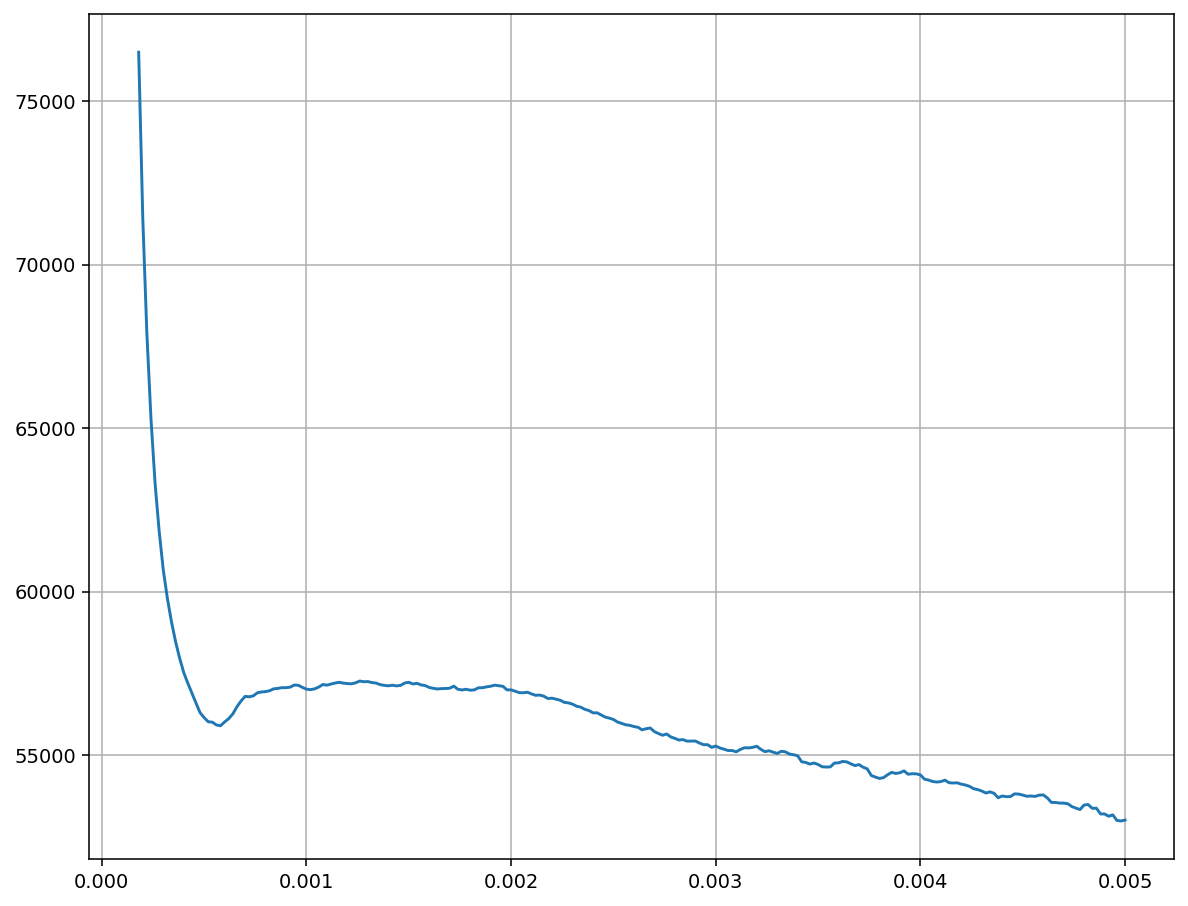

In [32]:
powers = {k: v for k, v in powers.items() if v < 80000}

figure(figsize=(10, 8), dpi=140)
plt.plot(powers.keys(), powers.values())
plt.grid()
plt.show()

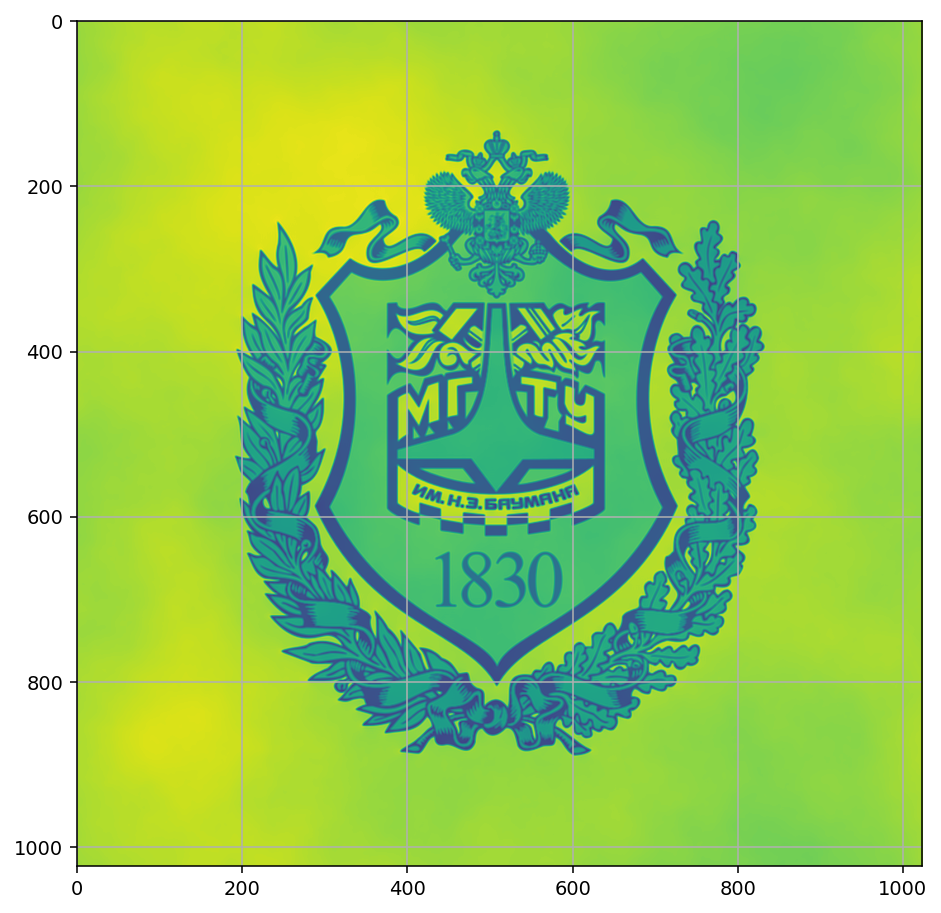

In [28]:
figure(figsize=(10, 8), dpi=140)
plt.imshow(retrieved_phases[0.0007000000000000001])
plt.grid()
plt.show()